# Atividade 04: Redes Convolucionais

Até esse momento, você trabalhou com redes profundas completamente conectadas, usando-as para explorar diferentes estratégias e arquiteturas de rede. Redes completamente conectadas representam um bom ambiente de teste para realização de diversos experimentos porque elas são muito eficientes, porém na prática a maioria dos resultados do *estado da arte* utilizam redes convolucionais (principalmente, no casos em que os dados de entrada são coleções de imagens).

Primeiramente, você irá implementar diversos tipos de camadas usados em redes convolucionais. Em seguida, você irá usar essas camadas para uma rede convolucional sobre a base de dados CIFAR-10.

In [1]:
# Executa algum código de inicialização desse notebook.
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from dl.classifiers.cnn import *
from dl.data_utils import get_CIFAR10_data
from dl.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from dl.layers import *
from dl.fast_layers import *
from dl.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # fixa tamanho default para as plotagens
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Um pouco mais de 'mágica', assim o notebook irá recarregar módulos python externos;
# veja mais em http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Carrega os dados brutos da base CIFAR-10.
# Para tanto, você deve ter feito o download de http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# e descompactado no diretório 'dl/datasets/cifar-10-batches-py'

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Camada de Convolução: *forward pass* ingênuo

O âmago de uma rede convolucional é a operação de convolução. No arquivo `dl/layers.py`, você irá implementar o *forward pass* da camada de convolução na função `conv_forward_naive`. 

Você não deve se preocupar muito sobre a eficiência neste momento; apenas escreva o código da forma que achar mais claro.

Você pode testar sua implementação executanto o seguinte código:

In [6]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare seu resultado com o correto; a diferença deve ser de cerca de 2e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


# Um a parte: Processamento de Imagem via convoluções

Como uma forma divertida de tanto realizar a verificação de sua implementação quanto obter um melhor entendimento do tipo de operações que camadas de convolução podem realizar, você irá fornecer duas imagens como entrada e definir manualmente filtros que são capazes de realizar operações comuns no processamento de imagens (tais como, conversão para escala de cinza e detecção de bordas).

Em seguida, o *forward pass* da camada de convolução será usado para aplicar esses filtros (ou operações) a cada uma das imagens de entrada.

Ao final, você poderá visualizar os resultados como forma de verificação.

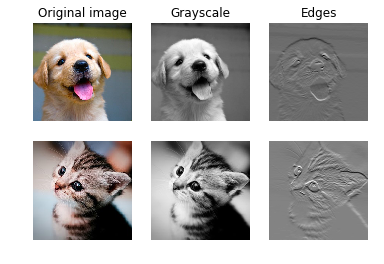

In [7]:
from scipy.misc import imread, imresize

import warnings
warnings.filterwarnings("ignore")

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# 'kitten' é muito larga, enquanto 'puppy' já apresenta ambas dimensões iguais (como um quadrado)
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Faça esse valor menor caso a execução seja muito lenta
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Definir pesos para camada convolucional relacionados a 2 filtros de tamanho 3x3
w = np.zeros((2, 3, 3, 3))

# O primeiro filtro converte a imagem para escala de cinza.
# Deve-se definir os canais vermelho, verde e azul do filtro.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# O segundo filtro detecta bordas horizontais no canal azul.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Quanto ao vetor de termos independentes: não é necessário
# nenhum viés adicional para o filtro de escala de cinza, 
# porém para o filtro de detecção de bordas é necessário se
# adicionar 128 a cada saída de forma que nada seja negativo.
b = np.array([0, 128])

# Computa o resultado da convolução de cada imagem de entrada em 'x' com 
# cada filtro em 'w', adicionando o offset 'b' e armazenando os resultados
# em 'out'.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Pequena função auxiliar para exibir imagens como uint8 e remover rótulos de eixos """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Exibe as imagens originais e os resultados das operações de convolução
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

# Camada de Convolução: *backward pass* ingênuo

Implemente agora o *backward pass* para a camada de convolução na função `conv_backward_naive` no arquivo `dl/layers.py`. Novamente, você não deve se preocupar muito com a eficiência computacional de seu código.

Quando você tiver concluído, execute o seguinte código para verificar numericamente sua implementação:

In [8]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Seus erros deve estar em torno de 1e-8
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.159803161159293e-08
dw error:  2.2471264748452487e-10
db error:  3.37264006649648e-11


# Camada de *Max Pooling*: *forward pass* ingênuo

Você deve implementar o *forward pass* da operação de *max pooling* na função `max_pool_forward_naive` no arquivo `dl/layers.py`. Novamente, Não se preocupe muito com a eficiência.

Verifique sua implementação, executando o seguinte código:

In [13]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare seu resultado com o correto. A diferença deve estar em torno de 1e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


# Camada de *Max Pooling*: *backward pass* ingênuo

Você deve implementar o *forward pass* da operação de *max pooling* na função `max_pool_backward_naive` no arquivo `dl/layers.py`. Novamente, Não se preocupe muito com a eficiência.

Verifique sua implementação utilizando a checagem numérica de gradiente por meio do seguinte código:

In [15]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Seu erro deve estar em torno de 1e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


# Implementação Eficiente de Camadas

Implementar camadas de convolução e *pooling* de forma eficiente pode ser desafiador. De modo a livrar você desse trabalho, você já receberá prontas as implementações eficientes das camadas de convolução e *pooling* no arquivo `dl/fast_layers.py`.

A implementação rápida de convolução depende de uma extensão Cython e para compilá-la (caso ainda não tenha sido feito) você deverá utilizar o seguinte comando a partir do diretório `dl`:

```bash
python setup.py build_ext --inplace
```

As funções da API para as versões rápidas das camadas de convolução e *pooling* permanecem exatamente iguais as das versões ingênuas que você implementou anteriormente: o *forward pass* recebe dados, pesos e parâmetros e produz as saídas e um objeto `cache`; enquanto o *backward pass* recebe as derivadas *upstream* e o objeto `cache` e produz os gradientes em relação aos dados e aos pesos.

**NOTA:** A implementação para *pooling* só irá executar de maneira ótima se as regiões de *pooling* não estiverem sobrepostas e cobrirem integralmente a entrada. Caso estas condições não sejam encontradas, o implementação rápida de *pooling* não será muito mais rápida que a ingênua.

Você pode comparar a performance das versões ingênuas e rápidas dessas camadas executando o código das próximas duas células:

In [16]:
from dl.fast_layers import conv_forward_fast, conv_backward_fast

import time 
current_time = lambda: int(round(time.clock() * 1000000000))

np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = current_time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = current_time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = current_time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % ((t1 - t0)/ 1000000000))
print('Fast: %fs' % ((t2 - t1)/ 1000000000))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = current_time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = current_time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = current_time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % ((t1 - t0)/ 1000000000))
print('Fast: %fs' % ((t2 - t1)/ 1000000000))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 12.453839s
Fast: 0.051594s
Speedup: 241.381537x
Difference:  1.970563140655889e-11

Testing conv_backward_fast:
Naive: 17.581324s
Fast: 0.041191s
Speedup: 426.824403x
dx difference:  9.43434568725122e-12
dw difference:  4.0793118881074517e-13
db difference:  0.0


In [17]:
from dl.fast_layers import max_pool_forward_fast, max_pool_backward_fast

np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = current_time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = current_time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = current_time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % ((t1 - t0)/ 1000000000))
print('fast: %fs' % ((t2 - t1)/ 1000000000))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = current_time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = current_time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = current_time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % ((t1 - t0)/ 1000000000))
print('fast: %fs' % ((t2 - t1)/ 1000000000))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.556366s
fast: 0.002828s
speedup: 196.734795x
difference:  0.0

Testing pool_backward_fast:
Naive: 2.408179s
fast: 0.015614s
speedup: 154.232035x
dx difference:  0.0


# "Sandwich" de Camadas Convolucionais

Anteriormente, você foi introduzido ao conceito de "sandwich" de camadas que combinou múltiplas operações em padrões comumente utilizados. No arquivo `dl/layer_utils.py`, você irá encontrar "sandwich" de camadas que implementam alguns padrões comumente utilizados na construção de redes convolucionais.

As duas células a seguir permitem que que você teste essas combinações.

In [18]:
from dl.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  4.397502834267091e-09
dw error:  3.651673815374511e-09
db error:  3.721670750819115e-10


In [19]:
from dl.layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  4.84744795054139e-09
dw error:  3.8283065057775625e-10
db error:  2.9449034603190923e-10


# Rede Convolucional de 3 Camadas

Agora, que você já implementou todas as camadas necessárias, você pode testá-las juntas para implementar uma rede convolucional simples.

Abra o arquivo `dl/classifiers/cnn.py` e estude a implementação da classe `ThreeLayerConvNet`.

Execute as próximas duas céludas para ajudá-lo a compreender a implementação.

## Verificação da Perda
Depois de construir sua nova rede, uma das primeiras verificações a se realizar é checar a perda. Quando se usa a perda *Softmax*, deve-se esperar que a perda para um conjunto de pesos aleatórios (e sem regularização) seja em torno de 
`log(C)` para `C` classes. Quando se adiciona regularização, este valor deve aumentar.

In [20]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.302586071243987
Initial loss (with regularization):  2.508255635671795


## Verificação de Gradiente

Depois que a perda se apresentar com valor razoável, deve-se usar a verificação numérica de gradiente para checar se seu *backward pass* está correto. Quanto fizer uma verificação numérica de gradientes, você deve usar um pequeno conjunto de dados artificiais e um pequeno número de neurônios em cada camada. Nota: implementações corretas pode ainda apresentar erros relativos em torno de 1e-2.

In [21]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10


## Sobreajuste de um Pequeno Conjunto de Dados

Um bom truque é treinar seu modelo com poucas amostras de dados. Você deverá ser capaz de sobreajustar (*overfit*) pequenos conjunto de dados, que irá resultar em grandes valores de acurácia de treinamento e comparativamente baixos valores de acurácia na validação.

In [22]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 30) loss: 2.414060
(Epoch 0 / 15) train acc: 0.190000; val_acc: 0.129000
(Iteration 2 / 30) loss: 2.604027
(Epoch 1 / 15) train acc: 0.230000; val_acc: 0.093000
(Iteration 3 / 30) loss: 2.111294
(Iteration 4 / 30) loss: 1.972190
(Epoch 2 / 15) train acc: 0.310000; val_acc: 0.096000
(Iteration 5 / 30) loss: 1.680646
(Iteration 6 / 30) loss: 1.822704
(Epoch 3 / 15) train acc: 0.570000; val_acc: 0.197000
(Iteration 7 / 30) loss: 1.665262
(Iteration 8 / 30) loss: 1.608396
(Epoch 4 / 15) train acc: 0.580000; val_acc: 0.194000
(Iteration 9 / 30) loss: 1.089637
(Iteration 10 / 30) loss: 1.380641
(Epoch 5 / 15) train acc: 0.730000; val_acc: 0.185000
(Iteration 11 / 30) loss: 0.822486
(Iteration 12 / 30) loss: 0.794665
(Epoch 6 / 15) train acc: 0.810000; val_acc: 0.261000
(Iteration 13 / 30) loss: 0.935201
(Iteration 14 / 30) loss: 0.563087
(Epoch 7 / 15) train acc: 0.860000; val_acc: 0.231000
(Iteration 15 / 30) loss: 0.381184
(Iteration 16 / 30) loss: 0.427029
(Epoch 8 / 15) tr

Exibindo os gráficos da perda, acurácias de treinamento e validação deve mostrar claramente o sobreajustamento (*overfitting*):

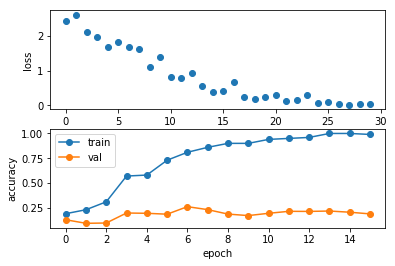

In [23]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Treinamento da Rede Convolucional de 3 Camadas

Por meio do treinamento da rede convolucional de 3 camadas por uma única época, você deverá alcançar uma acurácia acima de 40% sobre o conjunto de treinamento.

In [24]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.304740
(Epoch 0 / 1) train acc: 0.103000; val_acc: 0.107000
(Iteration 21 / 980) loss: 2.117106
(Iteration 41 / 980) loss: 2.012541
(Iteration 61 / 980) loss: 1.921082
(Iteration 81 / 980) loss: 1.733382
(Iteration 101 / 980) loss: 1.759544
(Iteration 121 / 980) loss: 1.521104
(Iteration 141 / 980) loss: 1.785777
(Iteration 161 / 980) loss: 1.888877
(Iteration 181 / 980) loss: 1.914580
(Iteration 201 / 980) loss: 1.914932
(Iteration 221 / 980) loss: 2.040809
(Iteration 241 / 980) loss: 1.664366
(Iteration 261 / 980) loss: 1.592180
(Iteration 281 / 980) loss: 1.837627
(Iteration 301 / 980) loss: 1.801446
(Iteration 321 / 980) loss: 1.884949
(Iteration 341 / 980) loss: 1.638730
(Iteration 361 / 980) loss: 1.768997
(Iteration 381 / 980) loss: 1.426742
(Iteration 401 / 980) loss: 1.673059
(Iteration 421 / 980) loss: 1.440578
(Iteration 441 / 980) loss: 1.786904
(Iteration 461 / 980) loss: 1.750115
(Iteration 481 / 980) loss: 1.620009
(Iteration 501 / 980) loss: 

## Visualizando os Filtros

Você pode visualizar os filtros convolucionais da primeira camada da rede treinada executando o seguinte código:

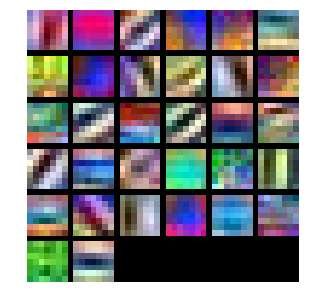

In [25]:
from dl.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# *Spatial Batch Normalization*

Você já observou que *batch normalization* é uma técnica muito útil para o treinamento de redes profundas completamente conectadas. Essa técnica também pode ser utilizada para redes convolucionais, porém é necessário ajustá-la um pouco; essa modificação será chamada de *spatial batch normalization*.

Normalmente, *batch normalization* recebe entradas com o formato `(N, D)` e produz saídas com o mesmo formato `(N, D)`, em que se normaliza o *minibatch* na dimensão `N`. Para dados vindos de uma rede convolucional, *batch normalization* precisa receber dados na forma `(N, C, H, W)` e produzir saídas na forma `(N, C, H, W)`, em que a dimensão `N` representa o tamanho do *minibatch* e as dimensões `(H, W)` fornecem o tamanho espacial do mapa de características (*features*).

Se o mapa de características (*features*) foi gerado usando convoluções, então deve-se esperar que as estatísticas de cada canal (*feature channel*) seja relativamente consistente tanto entre diferentes imagens quanto para diferentes regiões da mesma imagem. Dessa forma, *spatial batch normalization* calcula a média e variância para cada um dos `C` canais por meio do cálculo de estatísticas tanto sobre a dimensão do *minibatch* `N` quanto das dimensão espaciais `H` e `W`.

## *Spatial batch normalization*: *forward pass*

No arquivo `dl/layers.py`, você deve estudar a implementação do *forward pass* relativo a *spatial batch normalization* na função  `spatial_batchnorm_forward`. Verifique a implementação executando o seguinte código:

In [26]:
np.random.seed(231)
# Checa forward pass' durante o treinamento por meio da verificação de médias e variâncias
# de caracterísitcas tanto antes quanto depois do 'spatial batch normalization'

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Médias devem ser próximas de zero and desvios padrões devem ser próximos de um
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Médias devem ser próximas de 'beta' and desvios padrões devem ser próximos de 'gamma'
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [9.33463814 8.90909116 9.11056338]
  Stds:  [3.61447857 3.19347686 3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.18949336e-16  2.49800181e-17 -1.22124533e-16]
  Stds:  [0.99999962 0.99999951 0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [6. 7. 8.]
  Stds:  [2.99999885 3.99999804 4.99999798]


In [27]:
np.random.seed(231)
# Checa o 'forward pass' durante o teste por meio da execução do 'forward pass' em modo de 
# treinamento por várias vezes de forma a obter médias móveis significativas (aquecimento);
# para, em seguida, checar as médias e variâncias das ativações após o 'forward pass' em modo  
# de teste.
N, C, H, W = 10, 4, 11, 12

# Realiza "aquecimento" para se obter médias móveis significativas
bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
    x = 2.3 * np.random.randn(N, C, H, W) + 13
    spatial_batchnorm_forward(x, gamma, beta, bn_param)
    
# Altera para modo de teste de forma a utilizar as médias móveis obtidas anteriormente
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Médias devem estar próximas de zero e desvios padrões próximos de um,
# porém devem apresentar um 'ruído' maior que aquele observado durante o treinamento.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [0.96718744 1.0299714  1.02887624 1.00585577]


## *Spatial batch normalization*: *backward pass*

No arquivo `dl/layers.py`, você deve estudar a implementação do *backward pass* relativo a *spatial batch normalization* na função 
`spatial_batchnorm_backward`. Verifique a implementação executando o seguinte código:

In [28]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.786648193872555e-07
dgamma error:  7.0974817113608705e-12
dbeta error:  3.275608725278405e-12
